In [1]:
import os
from pathlib import Path
from cotnav.models.vlms.openaimodel import OpenAIModel
from cotnav.models.vlms.util import ResponsesMessage
from cotnav.dataset.dataset_helpers import get_mission_id
from cotnav.geometry.camera import (project_to_pixel)
from cotnav.utils.loader_utils import (load_intrinsics, load_odom, load_timestamps, build_transforms)
from cotnav.utils.math_utils import (interpolate_se3, odom_to_local_pose, transform_poses, se3_matrix)
from cotnav.utils.image_utils import (save_video)
from dotenv import load_dotenv
from decord import VideoReader
from decord import cpu, gpu
import numpy as np
import matplotlib.pyplot as plt


RM = ResponsesMessage()
load_dotenv()

True

In [2]:
model_args = {
    "model": "gpt-5",
    # Optional knobs:
    # "reasoning": {"effort": "high"},
    # "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
    # "temperature": 0.4,   # include only if your model supports sampling
    # "top_p": 0.95,        # "
    # "max_output_tokens": 600,
}



In [3]:
# instructions = "Follow the tasks below"
# messages = [
#     {"role": "developer", "content": [RM.input_text_message("Explain SE(3) in two sentences")]},
#     # {"role": "user", "content": [
#     #     RM.input_text_message("What are the key objects?"),
#     #     {"type": "input_image", "image_url": {"url": "https://example.com/scene.jpg"}},
#     # ]},
# ]

# m = OpenAIModel(service_tier="flex")
# resp = m.call(model_args=model_args, instructions=instructions, input=messages)
# print(resp.output_text)

In [4]:
mission_dir = Path("/robodata/arthurz/Research/cotnav/data/grandtour_raw/mission_2024-10-01-11-29-55")
video_path = mission_dir / "front_camera_lossy.mp4"
ts_path   = mission_dir / "front_camera_timestamps_anymal.csv"
odom_path = mission_dir / "odometry_data_anymal.csv"
info_path = mission_dir / "front_camera_info_anymal.yaml"
tf_path = mission_dir / "tf_static_anymal.yaml"
START_FRAME = 500
END_FRAME = 1500
FRAME_STEP = 10

assert all(p.exists() for p in [mission_dir, video_path, odom_path, info_path, ts_path, tf_path]), "One or more paths do not exist"

vr = VideoReader(str(video_path), ctx=cpu(0))
batch = vr.get_batch(np.arange(START_FRAME, END_FRAME, FRAME_STEP))


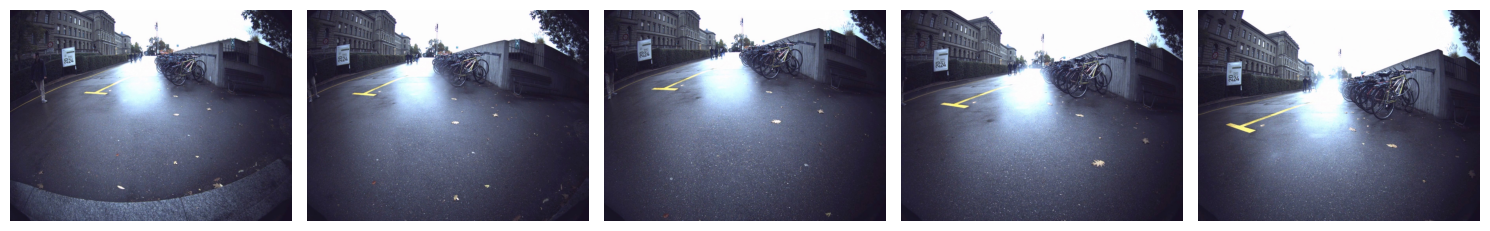

In [5]:
%matplotlib inline
frames = batch.asnumpy()

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Write batch to video file
save_video(frames, "test_output.mp4", fps=10)

In [6]:
odom = load_odom(odom_path)

calib = load_intrinsics(info_path, tf_path, world_frame="base")
cam_ts = load_timestamps(ts_path)
interp_odom = interpolate_se3(cam_ts, odom[:, 0], odom[:, 1:4], odom[:, 4:8])

print("Loaded odometry with shape:", odom.shape)
print("Loaded timestamps with shape:", cam_ts.shape)
print("Interpolated odometry shape:", interp_odom.shape)

print("Image shape (H, W):", calib.size_hw)
print("Intrinsics:\n", calib.K)
print("TF world to cam:\n", calib.T_world_cam)

Loaded odometry with shape: (3461, 8)
Loaded timestamps with shape: (3472,)
Interpolated odometry shape: (3472, 8)
Image shape (H, W): (1080, 1440)
Intrinsics:
 [[700.38943503   0.         682.88965131]
 [  0.         700.13138396 523.1354161 ]
 [  0.           0.           1.        ]]
TF world to cam:
 [[-2.03673102e-04 -9.99999556e-01 -9.19946282e-04  1.01805505e-02]
 [-1.72922519e-01  9.41307357e-04 -9.84934981e-01  2.86088419e-01]
 [ 9.84935410e-01 -4.15253346e-05 -1.72922634e-01 -4.01986356e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


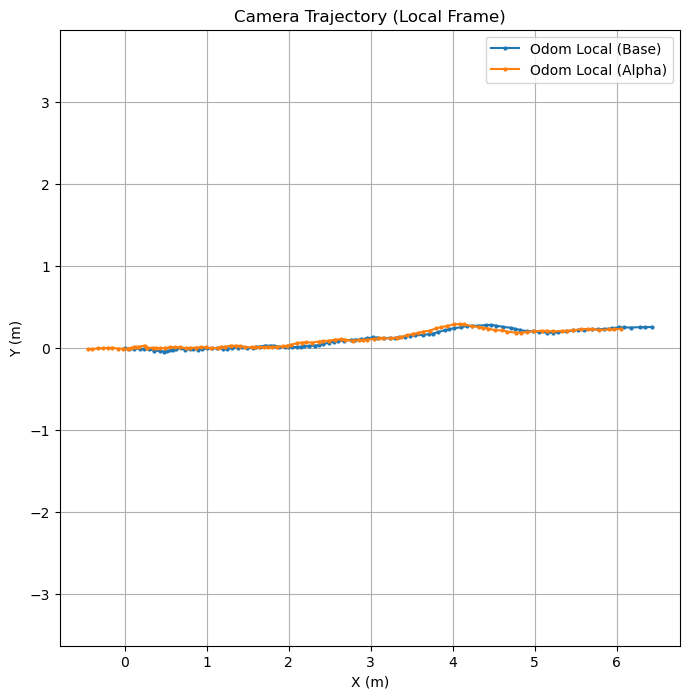

p_alpha_local shape  (100, 3)


In [14]:
tm = build_transforms(tf_path)

odom_window = odom[START_FRAME:START_FRAME + 100]
T_hesai_odom = se3_matrix(odom_window[:, 1:4], odom_window[:, 4:8])
T_base_hesai = tm.get_transform("hesai_lidar", "base") # tgt, src
T_base_odom = T_hesai_odom @ T_base_hesai
T_base_local = np.linalg.inv(T_base_odom[0]) @ T_base_odom
p_base_local = T_base_local[:, :3, 3]

T_alpha_base = tm.get_transform("base", "alphasense_front_center") # tgt, src

p_alpha_base = -T_alpha_base[:3, 3]
p_alpha_base_homo = np.hstack((p_alpha_base, 1))
p_alpha_local = T_base_local @ p_alpha_base_homo.T
p_alpha_local = p_alpha_local[:, :3]

# Transform odom poses from world to local frame (base)
# plot odom and interpolated odom
plt.figure(figsize=(8, 8))
plt.plot(p_base_local[:, 0], p_base_local[:, 1], marker='o', markersize=2, label='Odom Local (Base)')
plt.plot(p_alpha_local[:, 0], p_alpha_local[:, 1], marker='o', markersize=2, label='Odom Local (Alpha)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Camera Trajectory (Local Frame)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

print("p_alpha_local shape ", p_alpha_local[:, :3].shape)


UV: [[ 665.15268758   24.86112092]
 [ 682.76926234 1059.41481164]
 [ 681.65986304 1009.66408656]
 [ 692.53185946  965.42616394]
 [ 690.68425799  910.35740854]
 [ 677.27297814  894.56130344]
 [ 678.46081108  859.28493198]
 [ 668.30188914  826.46500744]
 [ 670.15743084  797.37997295]
 [ 672.54936466  778.23017342]
 [ 682.34786226  754.16393567]
 [ 683.29465841  723.94306013]
 [ 683.70625588  708.62131856]
 [ 680.87973541  693.9947731 ]
 [ 681.52800568  678.25136467]
 [ 680.49366195  666.73915584]
 [ 681.04212969  652.50546009]
 [ 680.41979879  634.99795059]
 [ 678.35560649  619.56261574]
 [ 674.87112459  605.71611589]
 [ 668.92945772  592.96482922]
 [ 661.98021931  578.3820245 ]
 [ 660.00163869  572.03770719]
 [ 659.42913866  560.09233829]
 [ 661.14102141  545.9351792 ]
 [ 657.88806942  534.29755336]
 [ 656.51253463  524.38559873]
 [ 655.55892576  516.07738395]
 [ 652.39626981  504.61464917]
 [ 651.6521084   499.89330048]
 [ 654.20459904  490.95999593]
 [ 659.12788496  482.70837134]
 [ 6

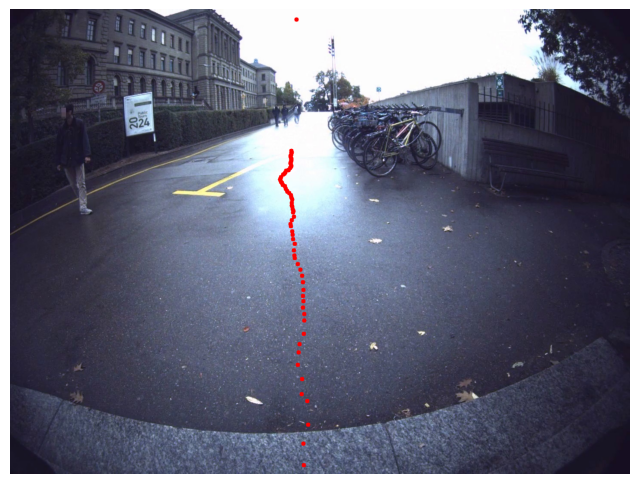

In [ ]:
# print("Camera odometry shape:", odom_local.shape)
# print("First 5 odom poses:\n", odom_local[:, 1:4])
uv = project_to_pixel(p_alpha_local, calib)
print("UV:", uv)

# Draw poitns with cv2 on image then show
import cv2
def draw_points_on_image(image, points, color=(0, 255, 0), radius=5):
    for i, (u, v) in enumerate(points):
        if i < 1:
            continue
        cv2.circle(image, (int(u), int(v)), radius, color, -1)
    return image

image_with_points = draw_points_on_image(frames[0].copy(), uv, color=(255, 0, 0), radius=5)
plt.figure(figsize=(8, 8))
plt.imshow(image_with_points)
plt.axis('off')
plt.show()